In [1]:
import sys
sys.path.insert(0, "..")

# New York City Taxi Fare Prediction 

🔗 [Kaggle Overview](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview)

## Goal

The main goal here is to create a model that, given some information about the pickup and dropoff locations, predict the fare amount for that taxi trip.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown

#### Training dataset size

In [4]:
!du -hs ../data/train.csv | cut -f1

5.3G


In [5]:
total_rows = !wc -l ../data/train.csv | cut -d' ' -f 2
total_rows = int(total_rows[0])

In [6]:
total_rows * 0.1

5542385.600000001

In [7]:
df = pd.read_csv("../data/train.csv", nrows=int(total_rows * 0.1))

## Relevant information

Before even start looking at the data itself, it's important for us to get a little more information about the rules for fare calculation in New York. Here are some resources about it coming from the [www.nyc.gov website page on taxi fares](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page):

#### Standard Metered Fare 💸

- \$2.50 initial charge.
- Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
- Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
- Plus 30 cents Improvement Surcharge.
- Plus 50 cents overnight surcharge 8pm to 6am.
- Plus \\$1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
- Plus New York State Congestion Surcharge of \\$2.50 (Yellow Taxi) or \\$2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
- Plus tips and any tolls.
- There is **no charge for extra passengers**, luggage or bags, or paying by credit card.
- The on-screen rate message should read: "Rate #01 – Standard City Rate."
- Make sure to always take your receipt.

## Fare

According to NYC Taxi's fare information we've just read, there is a minimal \$2.5 initial charge to all trips, so we should check for values bellow this threshold and remove from our dataset

In [8]:
invalid_fare = (df.fare_amount <= 2.5)

In [9]:
Markdown(f"**Invalid fair_amount rate:** {invalid_fare.mean().round(3)}")

**Invalid fair_amount rate:** 0.004

In [10]:
df = df[~invalid_fare]

## Coordinates

Here we'll explore coordinate values for each trip. We should keep in mind that this dataset is from New York, which has its center at (40.7127281, -74.0060152).
Any coordinate that falls way further from this point (up to an arbitrarily big radius), should be considered invalid and removed from further analysis

In [11]:
invalid_coordinates = (
    df.filter(regex="lon|lat").eq(0).any(axis=1) |
    df.filter(regex="lon|lat").isnull().any(axis=1) |
    df.filter(regex="lon").abs().gt(180).any(axis=1) |
    df.filter(regex="lat").abs().gt(90).any(axis=1)
)

In [12]:
Markdown(f"**Invalid coordinates rate:** {invalid_coordinates.mean().round(3)}")

**Invalid coordinates rate:** 0.02

In [13]:
df = df[~invalid_coordinates]

## Passenger count

In [14]:
invalid_passenger_count = df.passenger_count > df.passenger_count.quantile(0.98)

In [15]:
df = df[~invalid_passenger_count]

## Feature Engineering

## Distance

One of the most relevant features for predicting taxi fare ammounts must the distance between the pickup and dropoff spots. As you imagine, there are plenty of ways to calculate this distance. We could just take the euclidean distance, which is a good approximation for small distances but fails on larger distances, because it does not consider Earths roundness (~though some flatearthers may not agree with us~). For this, a better approximation is using **haversine** distance, which is a much better approximation for the real distance.

Now, both the euclidean and haversine distances are measuring only the straight (or almost straight) line between this two spots. A taxi driver, unfortunately cannot do it. So, the best approximation we could have is calculating the distance given the shortest possible street route.

In [16]:
from nyctf.training.features import haversine_distance

In [17]:
df["hav_distance_km"] = haversine_distance(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)

<AxesSubplot:ylabel='Frequency'>

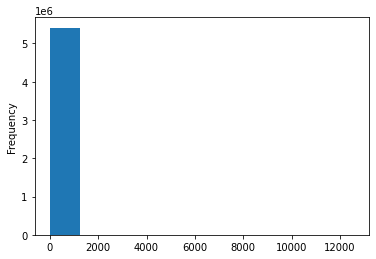

In [18]:
df.hav_distance_km.plot.hist()

In [19]:
invalid_trip_distances = df.hav_distance_km > df.hav_distance_km.quantile(0.99)

In [20]:
df = df[~invalid_trip_distances]

<AxesSubplot:ylabel='Frequency'>

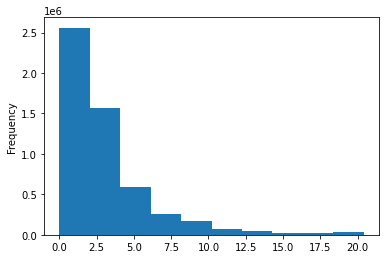

In [21]:
df.hav_distance_km.plot.hist()

## Time related features

In [22]:
df["pickup_datetime"] = pd.to_datetime(df.pickup_datetime)

In [23]:
df["hour"] = df.pickup_datetime.dt.hour

In [24]:
df["day_of_week"] = df.pickup_datetime.dt.day_of_week

AttributeError: 'DatetimeProperties' object has no attribute 'day_of_week'

In [ ]:
df.loc[~df.day_of_week.isin([5,6])]\
  .groupby("hour").fare_amount.median().plot.bar()

It looks like we have a peak median fare price between 3-5 o'clock for weekdays, which seems interesting.

In [ ]:
df.groupby("day_of_week").fare_amount.median().plot.bar()

In [ ]:
df = df.sort_values("pickup_datetime", ascending=True)

## Demand features

Now, let's see if somehow the fare amounts are correlated with demand. According to the NYC official info, it shouldn't.

In [ ]:
df_indexed = df.set_index(df.pickup_datetime)

In [ ]:
df_indexed["n_trips_up_to_30_min_before"] = df_indexed.rolling("30min").fare_amount.count()
df_indexed["n_trips_up_to_1_h_before"] = df_indexed.rolling("1h").fare_amount.count()

In [ ]:
plt.scatter(df_indexed.n_trips_up_to_30_min_before, df_indexed.fare_amount, alpha=0.1)
plt.xlabel("# trips up to 30 min before")
plt.ylabel("Fare amount")

In [ ]:
plt.scatter(df_indexed.n_trips_up_to_1_h_before, df_indexed.fare_amount, alpha=0.1)
plt.xlabel("# trips up to 1 hour before")
plt.ylabel("Fare amount")

No apparent correlation between the demand right before the trip and the fare amount.

## Passengers

In [ ]:
df.groupby("passenger_count").fare_amount.median().plot.bar()

In [ ]:
df.groupby("passenger_count").size().plot.bar()

## Conclusion

Features that can be used for training:

- hav_distance_km
- hour
- day_of_week